In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from matplotlib.colors import ListedColormap
import itertools

import trueskill
from scipy.stats import norm
from sqlalchemy import select, insert, update, create_engine, Date, and_
from sqlalchemy.orm import Session, aliased

import data
from match_report import read_player_skill_for_team, plot_match_qualities, plot_ridge_skill_distributions, plot_paired_skill_distributions, read_positions_for_player

In [2]:
# TODO Better layout for this notebook
# Functions in notebook for:
#   - Previous lineup
#   - Position distribution per player
#   - Get best possible lineup (with best 4 of them?) 

home_club = "Hannover 96"
away_club = "PDC Hannover e.V."
competition = "DBH Bezirksliga 2"
ignore_players = ["Frank Fuhlrott", "Timo Trauslen", "Andreas Schmidt", "Sven Rohde"]

home_players = read_player_skill_for_team(home_club, competition, ignore_players)
away_players = read_player_skill_for_team(away_club, competition)


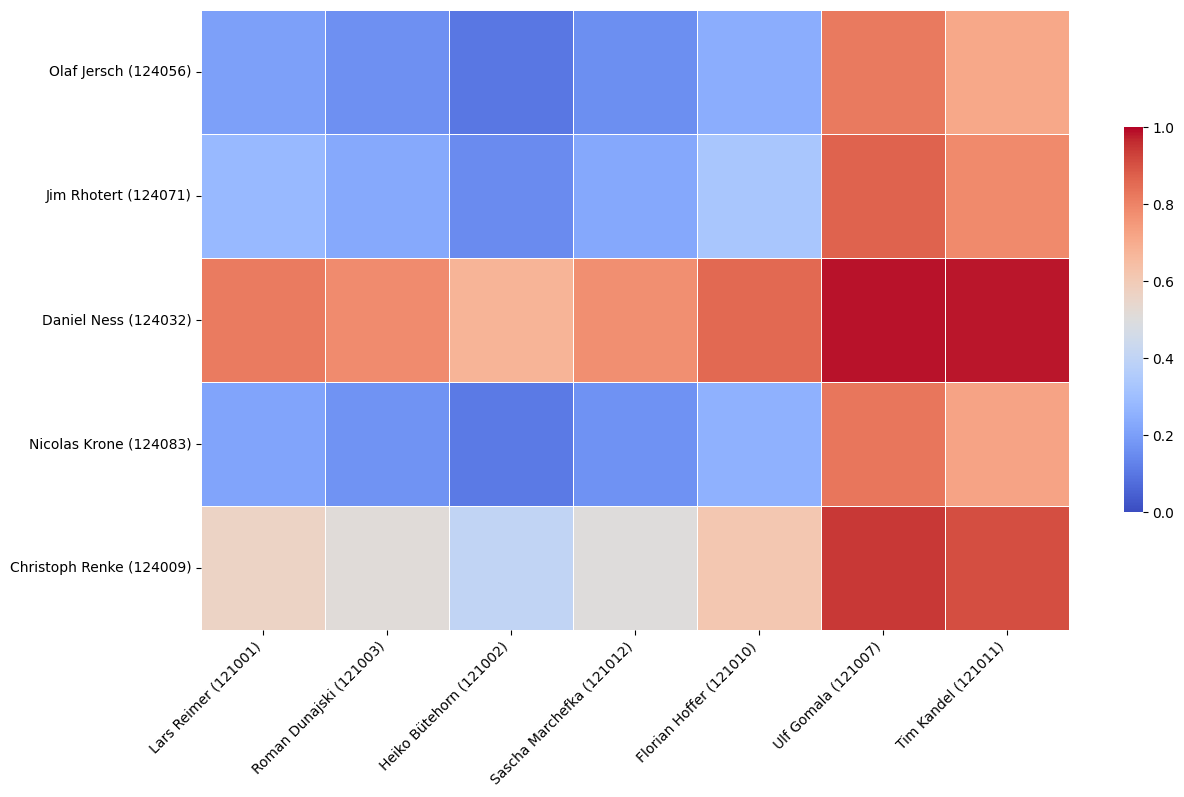

In [3]:
f = plot_match_qualities(home_players, away_players)

<Figure size 640x480 with 0 Axes>

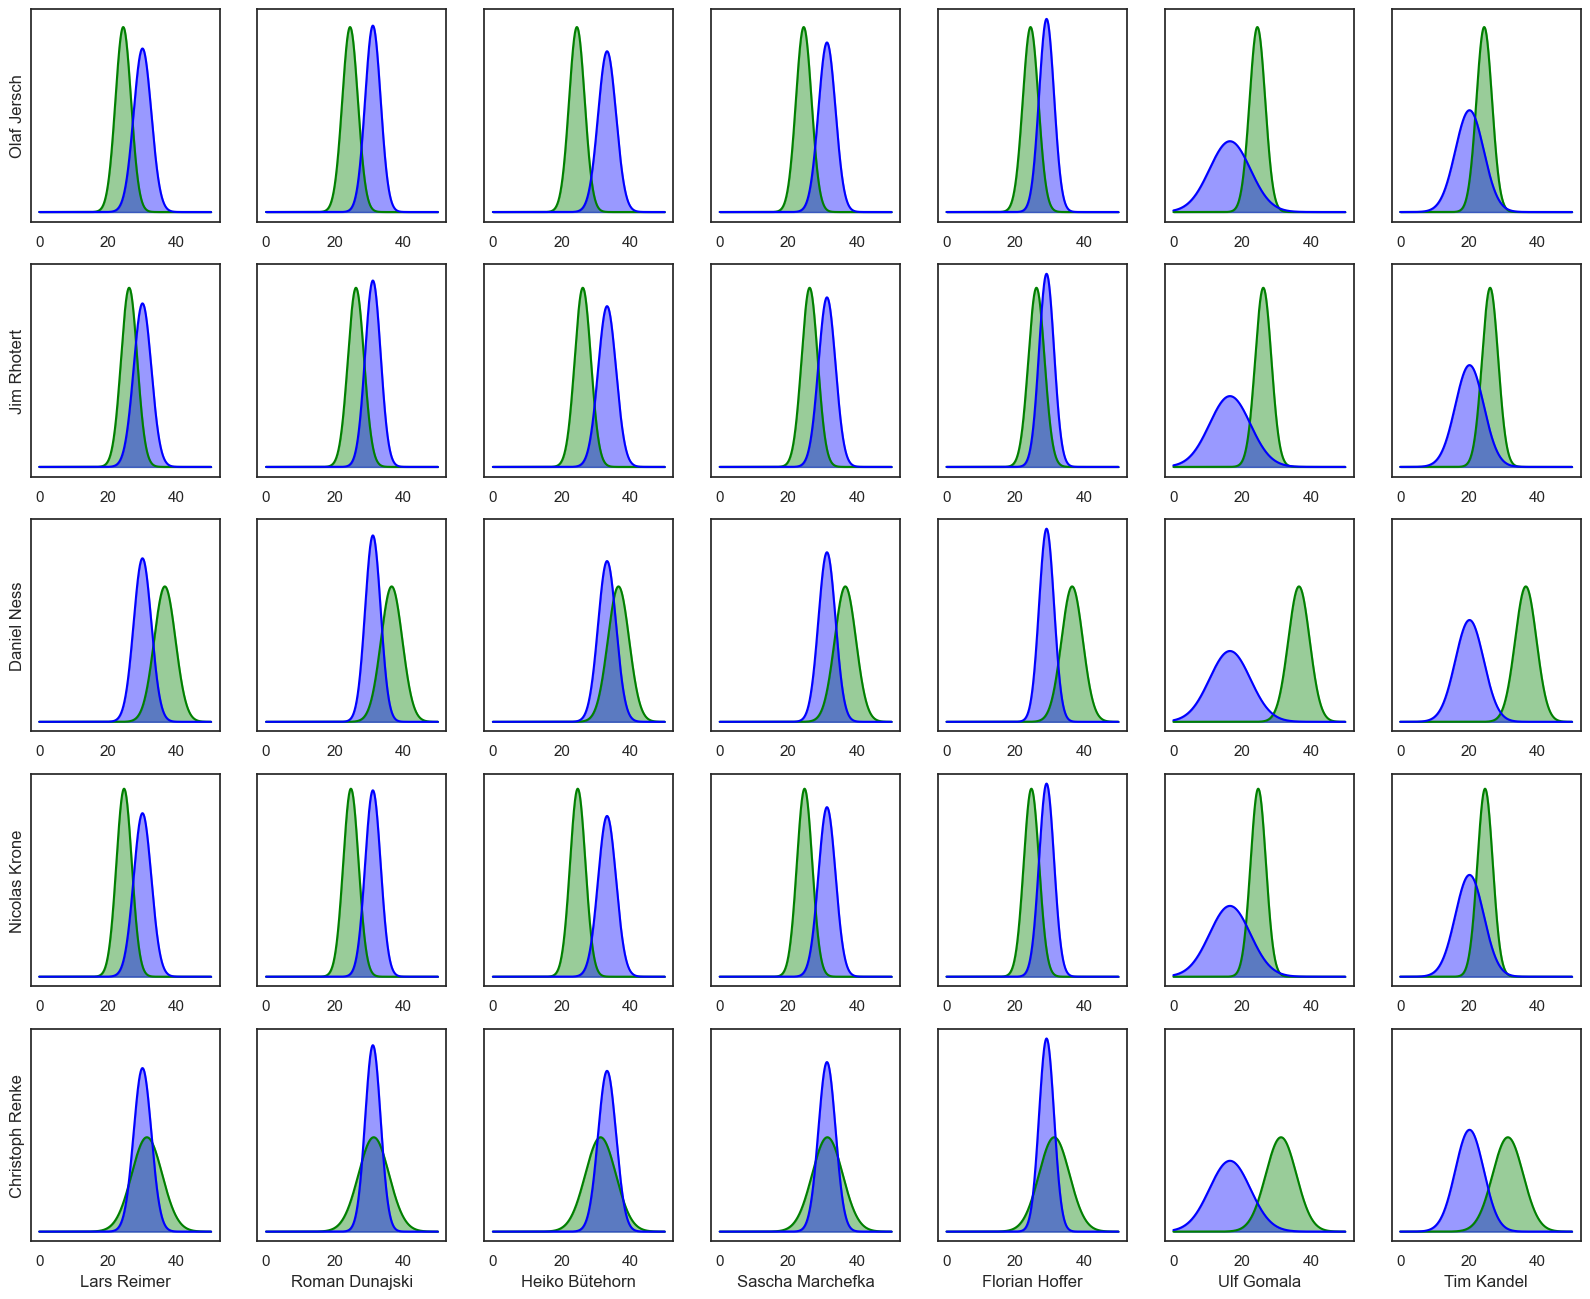

In [4]:
f = plot_paired_skill_distributions(home_players=home_players, away_players=away_players)


s:\Dokumente\Code\ndv-elo\src\match_report.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


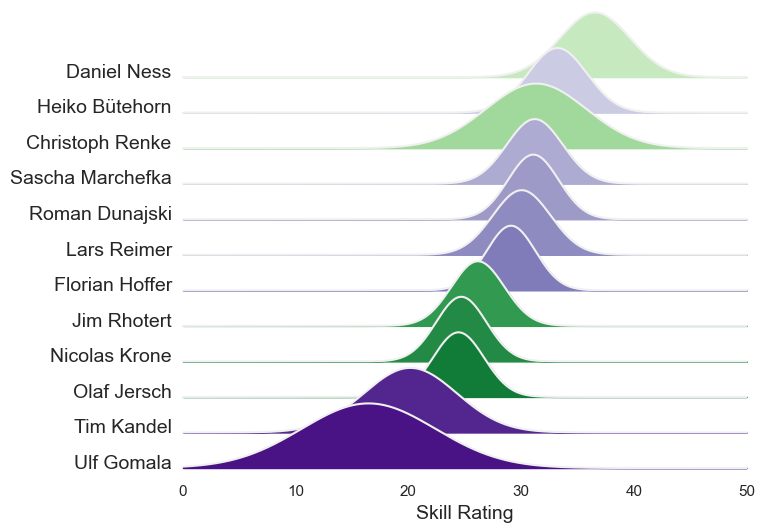

In [5]:
f = plot_ridge_skill_distributions(home_players=home_players, away_players=away_players)


[1 2]
[5 2]
[1, 2, 2, 1, 1, 1, 1]


([<matplotlib.axis.XTick at 0x2447b458070>,
 [Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3'), Text(4, 0, '4')])

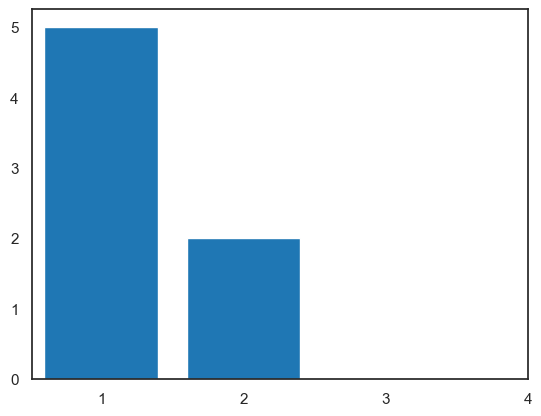

In [6]:
# plot previous lineup per player
home_positions, away_positions = read_positions_for_player(124032)
bins, occurences = np.unique(home_positions, return_counts=True)
plt.bar(bins, occurences)
plt.xticks(ticks=[1,2,3,4])
# TODO Group bars for home and away, subplots for players
